In [1]:
%load_ext autoreload
%autoreload 2

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv("../../azimuth.env")

# Add PATH_ROOT to Python path
import sys
sys.path.append(os.getenv("PATH_ROOT"))

print(f'Project path: {os.getenv("PATH_ROOT")}')


Project path: C:\\Users\\hoangdth\\alpha-azimuth


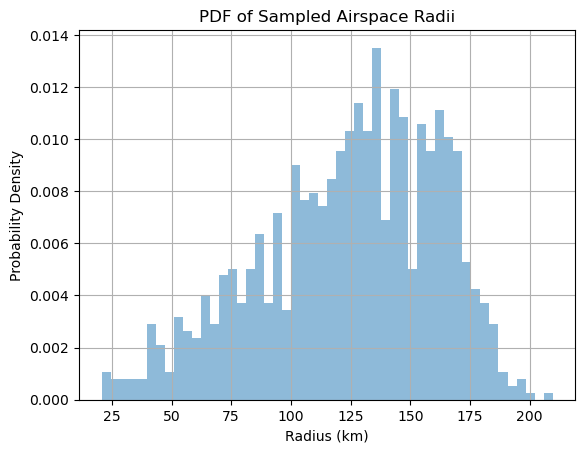

In [2]:
# Testing airspace radius sampling

import MARTINI.airspace.randomize_airspace as randomize_airspace
import matplotlib.pyplot as plt
radii = randomize_airspace.sample_airspace_radius(500, beta=3.0, N=1_000)

# Plot histogram of radii as PDF
plt.hist(radii, bins=50, density=True, alpha=0.5, label='Sampled Distribution')
plt.xlabel('Radius (km)')
plt.ylabel('Probability Density')
plt.title('PDF of Sampled Airspace Radii')
plt.grid(True)
plt.show()


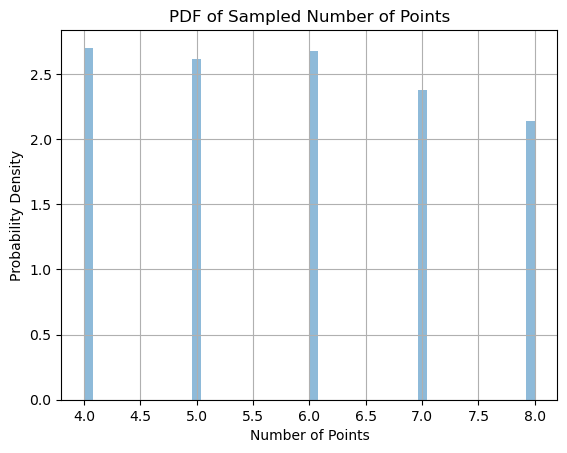

In [3]:
# Testing the number of points for the polygon

num_points = randomize_airspace.get_num_points_of_airspace(n_min=4, n_max=8)

# Plot histogram of number of points as PDF
plt.hist(num_points, bins=50, density=True, alpha=0.5, label='Sampled Distribution')
plt.xlabel('Number of Points')
plt.ylabel('Probability Density')
plt.title('PDF of Sampled Number of Points')
plt.grid(True)
plt.show()


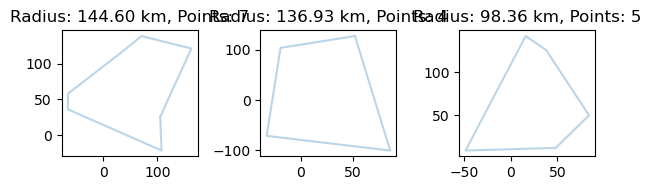

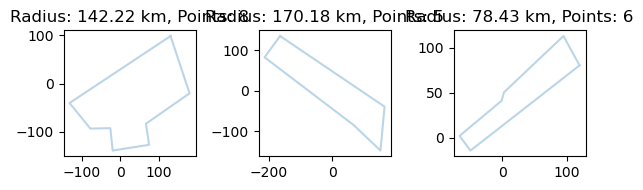

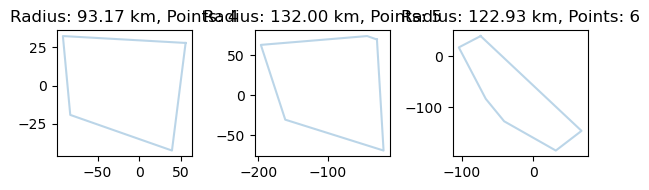

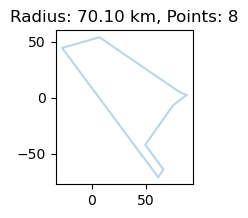

In [4]:
# Testing the unit polygon

import numpy as np

for i in range(10):
    radius = radii[i]
    n_points = num_points[i]

    # Create subplot grid with 3 columns
    if i % 3 == 0:
        fig = plt.figure(figsize=(6, 2))
    
    plt.subplot(1, 3, (i % 3) + 1)
    polygon, area = randomize_airspace.generate_unit_polygon(n_points, radius)
    plt.plot(np.append(polygon[:, 0], polygon[0, 0]), 
             np.append(polygon[:, 1], polygon[0, 1]), 
             alpha=0.3)
    plt.title(f'Radius: {radius:.2f} km, Points: {n_points}')
    
    # Close figure after every 3rd plot
    if i % 3 == 2:
        plt.tight_layout()



There are 9 parents generated
There are 19 entries generated
No intersection found for point 6: (412.3370510677642, 324.70396805297196)
There are 7 parents generated
There are 10 entries generated
No intersection found for point 4: (83.40070531664024, 519.634505200476)
No intersection found for point 5: (101.50085041588346, 506.7180800398908)
No intersection found for point 6: (114.07340155814738, 497.74619528337183)
No intersection found for point 7: (97.2768612207708, 509.732356445889)
There are 17 parents generated
There are 32 entries generated
No intersection found for point 10: (39.10075421433328, 551.2473458651873)
No intersection found for point 11: (48.19201554804411, 544.7597406007905)
There are 15 parents generated
There are 39 entries generated
No intersection found for point 0: (408.9145370723931, 326.53378941321483)
No intersection found for point 1: (396.744116681845, 333.04061311762615)
No intersection found for point 2: (413.412590598487, 324.12893893409506)
No interse

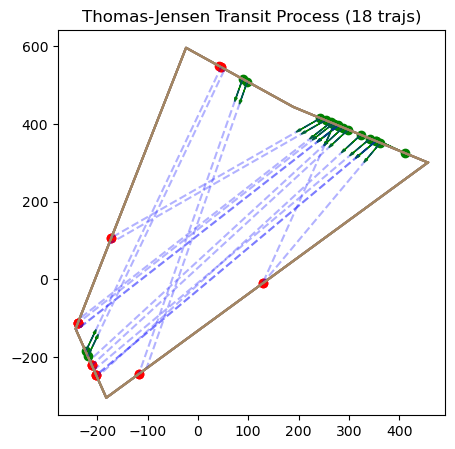

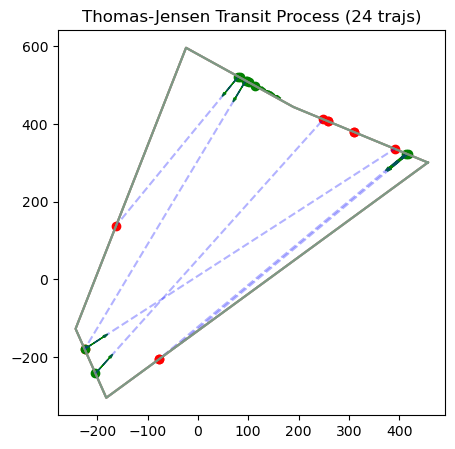

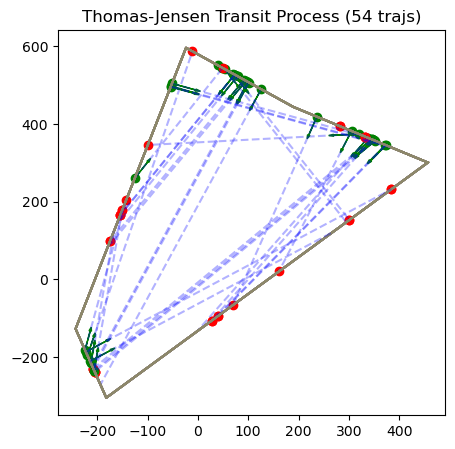

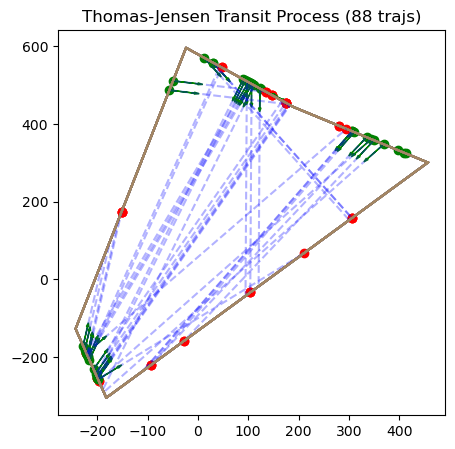

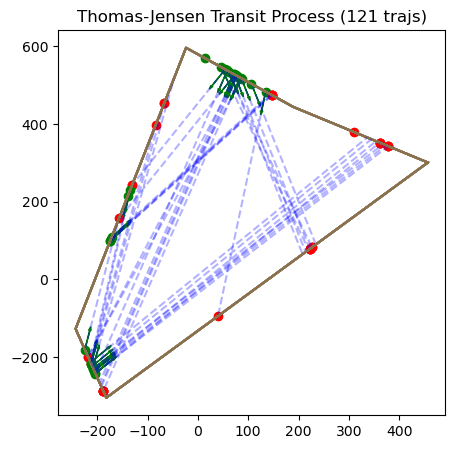

In [5]:
# These are development code
# For production, see the example below
# Testing Thomas-Jensen Transit Process

import MARTINI.arrivals.thomas as thomas
import MARTINI.airspace.geo as geo
import MARTINI.airspace.intersect as intersect

# Generate a polygon
polygon, area = randomize_airspace.generate_unit_polygon(5, 500, seed=69420)

# Disable random seed
np.random.seed(None)

trajectory_count = 0


for i in range(5): # generate 5 scenarios with the same airspace
    plt.figure(figsize=(5,5))

    # Generate points
    random_points, parent_indices, edge_points, transit_length = thomas.thomas_jensen_process(polygon, lambda_parent=8e-3, mu=2, sigma=12, min_transit_length=96, min_dist_to_vertex=42)
    # Find the exit points for each parent
    exit_points, velocity_vectors = thomas.get_exit_point_for_parent(polygon, random_points, parent_indices, restrict_exit_to_opposite_edge=False)

    print(f'There are {np.unique(parent_indices).shape[0]} parents generated')
    print(f'There are {len(random_points)} entries generated')
    # If there are no points, skip
    if len(random_points) == 0:
        print("No points generated")

    # Plot the entry points
    for i, point in enumerate(random_points):
        # Scatter the entry points
        plt.scatter(point[0], point[1], color='green')

        # Plot the polygon
        plt.plot(np.append(polygon[:, 0], polygon[0, 0]), 
                    np.append(polygon[:, 1], polygon[0, 1]), 
                    alpha=0.3)
        
        edge = edge_points[i]

        # Get parent index for this entry point
        parent_idx = parent_indices[i]
        parent_indices_unique = np.unique(np.array(parent_indices))
        parent_idx = np.where(parent_indices_unique == parent_idx)[0][0]
        # Get corresponding velocity vector
        velocity = velocity_vectors[parent_idx]

        # Scatter the exit point
        plt.scatter(exit_points[parent_idx][0], exit_points[parent_idx][1], color='red')
        
        # intersection = geo.find_line_polygon_intersection(point, velocity, polygon)
        intersection, valid_path = intersect.find_intersection(polygon, velocity, point)
        if intersection is not None and valid_path:
            # Plot the trajectory
            plt.plot([point[0], intersection[0]], [point[1], intersection[1]],
                    'b--', alpha=0.3)
            # Scatter plot the intersection
            # plt.scatter(intersection[0], intersection[1], color='blue')
            trajectory_count += 1
        else:
            print(f'No intersection found for point {i}: {point}')

        # Arrow the velocity vector
        plt.arrow(point[0], point[1], 
                velocity[0]*50, velocity[1]*50,  # Scale velocity for visibility
                head_width=5, head_length=10, 
                fc='blue', ec='green', alpha=1.)
        
    plt.title(f'Thomas-Jensen Transit Process ({trajectory_count} trajs)')


In [44]:
# Testing Thomas-Jensen Transit Process

import MARTINI.arrivals.thomas as thomas
import MARTINI.airspace.geo as geo
import MARTINI.airspace.intersect as intersect

# Generate a polygon
polygon, area = randomize_airspace.generate_unit_polygon(5, 500, seed=69420)

entry_points, exit_points, velocity_vectors, parent_indices = thomas.generate_problem_thomas_jensen(polygon, lambda_parent=12e-3, mu=3, sigma=25, min_dist_to_vertex=42, min_transit_length=96)
print(f'There are {len(entry_points)} entries generated')
print(f'There are {len(exit_points)} exits generated')
print(f'There are {len(velocity_vectors)} velocity vectors generated')


There are 82 entries generated
There are 82 exits generated
There are 82 velocity vectors generated


adjustText not available, keeping simple text labels


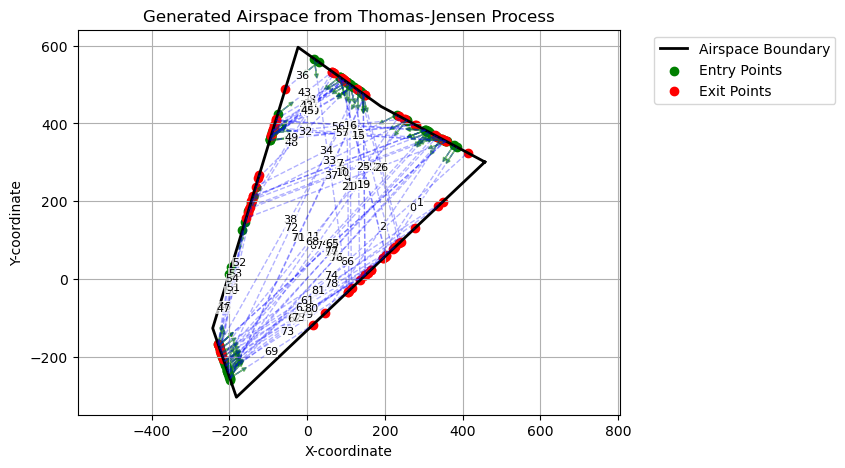

In [45]:

thomas.visualize_airspace(polygon, entry_points, exit_points, velocity_vectors)

# Assign arrival time according to a Markov Process

In [79]:
# Generate the arrival times
from MARTINI.arrivals.markov import MarkovArrivalProcess, standardize_D0_D1

# Define the transition matrix: D0 is transition without arrivals, D1 is transition with arrivals
D0 = np.array([[-10.5, 1],
                   [2, -30.0]]) / 30 # the diagonal elems of this array is not important
D1 = np.array([[0, 7.0], 
                [6.0, 0]]) / 28 # note: -3 = 1 + 1.5 + 0.5 (all the elements in the same row of two matrices (not each matrix) sum to 0)
# D1[2,1] / D1[1,2]: mixture of regular and burst behavior
D0, D1 = standardize_D0_D1(D0, D1)

map_process = MarkovArrivalProcess(D0, D1)

# Generate arrivals for time period T=10
arrivals = map_process.generate_arrivals(T=7200, seed=42, min_separation=37)

print(f'Total number of arrivals in 7200 seconds: {len(arrivals)}')


Total number of arrivals in 7200 seconds: 110


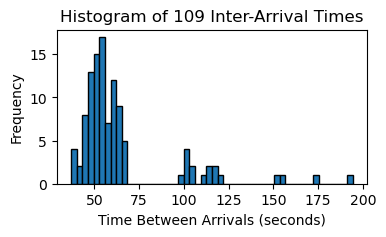

In [80]:
# Compute inter-arrival times and plot histogram
inter_arrival_times = np.diff(arrivals)
plt.figure(figsize=(4, 2))
plt.hist(inter_arrival_times, bins=50, edgecolor='black')
plt.title(f'Histogram of {len(inter_arrival_times)} Inter-Arrival Times')
plt.xlabel('Time Between Arrivals (seconds)')
plt.ylabel('Frequency')
plt.show()


In [81]:
from IPython.display import Markdown

# Check if inter-arrival times length match the number of entry points
if len(arrivals) != len(entry_points):
    display(Markdown(f'<font color="amber">**Warning**: Length of arrival times ({len(arrivals)}) does not match the number of entry points ({len(entry_points)})</font>'))
    if len(arrivals) > len(entry_points):
        print(f'Truncating arrival times to match the number of entry points')
        arrivals = arrivals[:len(entry_points)]
        print(f'The maximum arrival time for this scenario is {arrivals.max():.1f} s')
    else:
        raise ValueError(f'Length of arrival times ({len(arrivals)}) does not match the number of entry points ({len(entry_points)})')


<font color="amber">**Warning**: Length of arrival times (110) does not match the number of entry points (82)</font>

Truncating arrival times to match the number of entry points
The maximum arrival time for this scenario is 5445.4 s


# Assigning arrival times to each trajectory

In [82]:
arrival_times = thomas.assign_arrival_times_to_trajectories(entry_points, exit_points, arrivals, parent_indices, mode='uniform')

In [83]:
print(f'First 5 trajectories')
print(f'Entry points: {entry_points[:5]}')
print(f'Exit points: {exit_points[:5]}')
print(f'Arrival times: {arrival_times[:5]}')


First 5 trajectories
Entry points: [(376.8781759695923, 343.66178886906573), (385.35448087999015, 339.1299962154916), (344.42960203448473, 361.0101748146553), (315.75366145173496, 376.3415507197175), (310.2888847866683, 379.2632524524846)]
Exit points: [(164.20712277637983, 23.599358196940386), (195.1848806904266, 52.931458319876526), (45.61959216681515, -88.68834612378538), (-215.97780751063738, -205.23462136528042), (-218.20047524220502, -198.76689421726678)]
Arrival times: [1396.53785963 4130.10174449 5445.39062939 1458.77356867 2505.42069515]


In [84]:
import matplotlib.animation as animation
from datetime import datetime
import os

# Convert 450 knots to meters per second
SPEED = 450 * 0.514444 / 1000 # knots to km/s

def interpolate_position(entry, exit, progress):
    """Interpolate position between entry and exit points"""
    return (
        entry[0] + (exit[0] - entry[0]) * progress,
        entry[1] + (exit[1] - entry[1]) * progress
    )

# Create videos directory if it doesn't exist
os.makedirs('videos', exist_ok=True)

# Setup the figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min(p[0] for p in entry_points + exit_points) - 100, 
            max(p[0] for p in entry_points + exit_points) + 100)
ax.set_ylim(min(p[1] for p in entry_points + exit_points) - 100,
            max(p[1] for p in entry_points + exit_points) + 100)

# Plot polygon boundary
coords = polygon
ax.plot(np.append(coords[:, 0], coords[0, 0]), 
        np.append(coords[:, 1], coords[0, 1]), 'k-')

# Initialize empty scatter plot for aircraft
scat = ax.scatter([], [], c='red', marker='o')
timestamp_text = ax.text(0.02, 0.98, '', transform=ax.transAxes)
ax.set_title('Simulation of Thomas Jensen Transit Process')

def init():
    """Initialize animation"""
    scat.set_offsets(np.zeros((0, 2)))
    timestamp_text.set_text('')
    return scat, timestamp_text

def animate(frame):
    """Animation function"""
    current_time = frame  # Each frame represents one second
    
    # Find active aircraft
    active_positions = []
    
    for entry, exit, arrival_time in zip(entry_points, exit_points, arrival_times):
        # Calculate distance between entry and exit
        # print(f'Arrival time: {arrival_time:.1f} s')
        distance = np.sqrt((exit[0] - entry[0])**2 + (exit[1] - entry[1])**2)
        transit_time = distance / SPEED
        
        # Check if aircraft is active
        if arrival_time <= current_time and current_time <= arrival_time + transit_time:
            progress = (current_time - arrival_time) / transit_time
            pos = interpolate_position(entry, exit, progress)
            active_positions.append(pos)
    
    if active_positions:
        scat.set_offsets(active_positions)
        if (len(active_positions) > 1):
            # print(f'There are {len(active_positions)} active aircraft at time {current_time:.1f} s')
            pass
    else:
        # print(f'No active aircraft at time {current_time:.1f} s')
        scat.set_offsets(np.zeros((0, 2)))
        
    timestamp_text.set_text(f'Time: {current_time:.1f} s')
    return scat, timestamp_text

# Calculate animation duration
max_time = max(arrival_times) + max([np.sqrt((ex[0] - en[0])**2 + (ex[1] - en[1])**2) / SPEED 
                                   for en, ex in zip(entry_points, exit_points)])

max_time = 3600
print(f'Setting animation duration to {max_time} s')

# Create animation
anim = animation.FuncAnimation(fig, animate, init_func=init,
                             frames=np.arange(0, max_time, 60),
                             interval=12, blit=True)

# Save animation
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
anim.save(f'videos/{timestamp}.gif', writer='pillow', fps=20)
plt.close()


Setting animation duration to 3600 s
